<a href="https://colab.research.google.com/github/DanielP53/Labs-SP1/blob/master/Copy_of_lesson3_text_classifier_multilabel_transfer_learning_no_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, GlobalAveragePooling1D

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os, re, json, functools

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

In [73]:
pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


#Dataset

In [0]:
os.environ['KAGGLE_USERNAME'] = "danielp53"
os.environ['KAGGLE_KEY']='624437912e873e8045b8546a12db2b5e'


In [75]:
#https://www.kaggle.com/rounakbanik/the-movies-dataset
!kaggle datasets download rounakbanik/the-movies-dataset

the-movies-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [76]:
!unzip -o 'the-movies-dataset.zip'

Archive:  the-movies-dataset.zip
  inflating: credits.csv             
  inflating: keywords.csv            
  inflating: links.csv               
  inflating: links_small.csv         
  inflating: movies_metadata.csv     
  inflating: ratings.csv             
  inflating: ratings_small.csv       


In [77]:
os.listdir()

['.config',
 'links.csv',
 'ratings.csv',
 'movies_metadata.csv',
 'ratings_small.csv',
 'links_small.csv',
 'credits.csv',
 'the-movies-dataset.zip',
 'keywords.csv',
 'sample_data']

In [78]:
movies = pd.read_csv('movies_metadata.csv')
movies.head

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<bound method NDFrame.head of        adult  ... vote_count
0      False  ...     5415.0
1      False  ...     2413.0
2      False  ...       92.0
3      False  ...       34.0
4      False  ...      173.0
...      ...  ...        ...
45461  False  ...        1.0
45462  False  ...        3.0
45463  False  ...        6.0
45464  False  ...        0.0
45465  False  ...        0.0

[45466 rows x 24 columns]>

In [79]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [80]:
movies.genres

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45466, dtype: object

In [81]:
movies.overview

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
45461          Rising and falling between a man and woman.
45462    An artist struggles to finish his work while a...
45463    When one of her hits goes wrong, a professiona...
45464    In a small town live two brothers, one a minis...
45465    50 years after decriminalisation of homosexual...
Name: overview, Length: 45466, dtype: object

In [0]:
movies = movies[movies['imdb_id'] != '0']
movies = movies[movies['genres'] != "[]"]
movies = movies[~pd.isna(movies['overview'])]

#overview = movies['overview']
#genres = movies['genres']

dataset = movies[['overview', 'genres']] 

In [83]:
len(dataset)

42324

In [84]:
#DATASET_SIZE = len(genres)
#CLASS_NAMES = ['Drama','Comedy','Thriller','Romance','Action','Horror','Crime','Documentary','Adventure','Science Fiction']
CLASS_NAMES = ['Drama','Comedy','Thriller','Romance','Action']
CLASS_COUNT = len(CLASS_NAMES)
CLASS_COUNT

5

In [85]:
dataset.iloc[0]['genres']

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

In [86]:
dataset['genres'].replace("\'", "\"", regex=True, inplace=True)
dataset.iloc[0]['genres']

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


'[{"id": 16, "name": "Animation"}, {"id": 35, "name": "Comedy"}, {"id": 10751, "name": "Family"}]'

In [0]:
#genre_to_id = dict()
label_count = dict()

def genre_to_list(str_genre):
  keep = True
  genre_list = list(map(lambda genre:genre['name'],json.loads(str_genre)))
  
  for genre in genre_list:
    count = label_count.get(genre, 0) + 1
    label_count[genre] = count
    if (count > 5000):
      keep = False
    #if (genre_to_id.get(genre,-1) == -1):
    #  genre_to_id[genre] = len(genre_to_id.keys())
  genres_as_ids = list(map(lambda x: CLASS_NAMES.index(x), filter(lambda x: x in CLASS_NAMES, genre_list)))
  #genres_as_ids = list(map(lambda x:genre_to_id[x], genre_list)) 
  genres_one_hot = list()

  if (len(genres_as_ids) > 0 and keep):
    genres_one_hot = tf.keras.utils.to_categorical(genres_as_ids, CLASS_COUNT, dtype='int')
    genres_one_hot = functools.reduce(lambda x,y : x+y,genres_one_hot)

  return genres_one_hot

In [88]:
dataset['genres'] = dataset['genres'].apply(lambda x: genre_to_list(x))
dataset.iloc[0]['genres']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


array([0, 1, 0, 0, 0])

In [89]:
dataset = dataset[~dataset['genres'].str.len().eq(0)]
len(dataset)

11869

In [90]:
sorted(label_count.items(), key=lambda x: x[1], reverse=True)

[('Drama', 20023),
 ('Comedy', 12806),
 ('Thriller', 7586),
 ('Romance', 6673),
 ('Action', 6565),
 ('Horror', 4660),
 ('Crime', 4269),
 ('Documentary', 3886),
 ('Adventure', 3470),
 ('Science Fiction', 3028),
 ('Family', 2732),
 ('Mystery', 2451),
 ('Fantasy', 2290),
 ('Animation', 1920),
 ('Foreign', 1599),
 ('Music', 1588),
 ('History', 1379),
 ('War', 1310),
 ('Western', 1035),
 ('TV Movie', 751)]

In [0]:
#CLASS_NAMES = list(genre_to_id.keys())
#CLASS_COUNT == len(CLASS_NAMES), CLASS_NAMES

##Split dataset

In [92]:
train_split = dataset.sample(frac = 0.7,random_state=42)
test_split = dataset.drop(train_split.index).sample(frac = 0.5)
validation_split = dataset.drop(train_split.index).drop(test_split.index)

train_split.shape, validation_split.shape, test_split.shape

((8308, 2), (1781, 2), (1780, 2))

In [93]:
train_split.iloc[0]

overview    Christopher Walken shines in this cult-favorit...
genres                                        [1, 1, 1, 0, 1]
Name: 1701, dtype: object

In [94]:
train_labels = train_split['genres']
test_labels = test_split['genres']
validation_labels = validation_split['genres']
train_labels.shape, test_labels.shape, validation_labels.shape

((8308,), (1780,), (1781,))

In [95]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_split['overview'], train_split['genres']))
test_dataset = tf.data.Dataset.from_tensor_slices((test_split['overview'], test_split['genres']))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_split['overview'], validation_split['genres']))
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.int32, name=None))

In [96]:
overview, genres = next(iter(train_dataset))
overview, genres

(<tf.Tensor: shape=(), dtype=string, numpy=b'Christopher Walken shines in this cult-favorite dark comedy as Charlie, a former mobster who is abducted by five privileged young men (Sean Patrick Flanery, Johnny Galecki, Jay Mohr, Jeremy Sisto, Henry Thomas) desperate to raise a $2 million ransom to save the sister of a friend. As Charlie plays mind games, however, his captors splinter -- each wondering whether one of their own had a hand in the crime.'>,
 <tf.Tensor: shape=(5,), dtype=int32, numpy=array([1, 1, 1, 0, 1], dtype=int32)>)

In [0]:
batch_size = 128
shuffle_buffer_size = 1000

In [0]:
train_dataset = train_dataset.shuffle(shuffle_buffer_size).repeat().batch(batch_size)
validation_dataset = validation_dataset.shuffle(shuffle_buffer_size).batch(batch_size)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size)

In [99]:
overview, genres = next(iter(train_dataset))
overview.shape, genres.shape

(TensorShape([128]), TensorShape([128, 5]))

#Model

In [0]:
epochs = 20
train_steps = 10
validation_steps = 5

##Keras Layer

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 645       
Total params: 124,659,845
Trainable params: 17,157
Non-trainable params: 124,642,688
_________________________________________________________________
Train for 10 steps, validate for 5 steps
Epoch 1/20
10/10 [==============================] - 3s 278ms/step - loss: 0.6464 - accuracy: 0.6888 - val_loss: 0.6570 - val_accuracy: 0.6653
Epoch 2/20
10/10 [==============================] - 2s 249ms/step - loss: 0.6407 - accuracy: 0.6828 - val_loss: 0.6618 - val_accuracy: 0.6563
Epoch 3/20
10/10 [======================

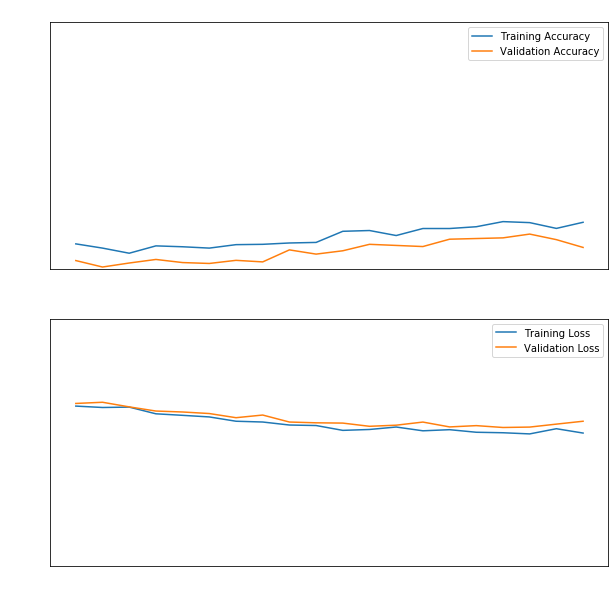

In [101]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                           output_shape=[128], input_shape=[], dtype=tf.string)

model = Sequential([
    hub_layer,
    Dense(128, activation='relu'),  
    Dense(CLASS_COUNT, activation='softmax'),
])

model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    epochs=epochs,
                    steps_per_epoch=train_steps,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps
                   )

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.setp(plt.legend().get_texts(), color='black')
plt.ylabel('Cross Entropy')
plt.ylim([0.0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [102]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=3)

print('Loss:', test_loss)
print('Accuracy:', test_acc)

Loss: 0.5343411905424935
Accuracy: 0.7226967


In [103]:
features, labels = next(iter(test_dataset))

test_index = np.random.randint(features.shape[0])
test_input = features[test_index]
test_label = labels[test_index]
predictions = model.predict(tf.expand_dims(test_input, axis=0))

expected_labels = np.array(CLASS_NAMES)[np.argwhere(test_label == 1)].flatten()

predicted_labels = ""
for i in (-predictions[0]).argsort()[:2]:
  predicted_labels += CLASS_NAMES[i] + " (" + str(np.around(predictions[0][i], decimals=2)) + ")\n"

print('Input',test_input)
print('Expected labels',expected_labels)
print('\nTop 2 predicted labels are:\n', predicted_labels)

Input tf.Tensor(b'Angela Bennett is a freelance software engineer who lives in a world of computer technology. When a cyber friend asks Bennett to debug a new game, she inadvertently becomes involved in a conspiracy that will soon turn her life upside down. While on vacation in Mexico, her purse is stolen. She soon finds that people and events may not be what they seem as she becomes the target of an assassination. Her vacation is ruined.  She gets a new passport at the U.S. Embassy in Mexico but it has the wrong name, Ruth Marx. When she returns to the U.S. to sort things out, she discovers that Ruth Marx has an unsavory past and a lengthy  police record. To make matters worse, another person has assumed her real identity ...', shape=(), dtype=string)
Expected labels ['Drama' 'Thriller' 'Action']

Top 2 predicted labels are:
 Thriller (0.48)
Drama (0.23)



In [104]:
test_input = "The Imperial Forces -- under orders from cruel Darth Vader (David Prowse) -- hold Princess Leia (Carrie Fisher) hostage, in their efforts to quell the rebellion against the Galactic Empire. Luke Skywalker (Mark Hamill) and Han Solo (Harrison Ford), captain of the Millennium Falcon, work together with the companionable droid duo R2-D2 (Kenny Baker) and C-3PO (Anthony Daniels) to rescue the beautiful princess, help the Rebel Alliance, and restore freedom and justice to the Galaxy."
predictions = model.predict(tf.expand_dims(test_input, axis=0))
predicted_labels = ""
for i in (-predictions[0]).argsort()[:2]:
  predicted_labels += CLASS_NAMES[i] + " (" + str(np.around(predictions[0][i], decimals=2)) + ")\n"

print('\nTop 2 predicted labels are:\n', predicted_labels)


Top 2 predicted labels are:
 Action (0.89)
Comedy (0.04)

